In [1]:
import os
from datasets import load_dataset
from PIL import Image
import pandas as pd
import torch

In [2]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [3]:
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None)     # Show all rows
pd.set_option('display.max_colwidth', None) # Show full content of each column (no truncation)
pd.set_option('display.width', None)

In [4]:
dataset = load_dataset("ahmedheakl/arocrbench_arabicocr",split="train")

In [5]:
dataset

Dataset({
    features: ['image', 'source', 'text'],
    num_rows: 50
})

In [6]:
results = []
for sample in dataset:
    image = sample["image"]  # Already a PIL Image object
    if image.mode != "RGB":
        image = image.convert("RGB")
    ground_truth = sample["text"]
    results.append({
        "image": image,
        "ground_truth": ground_truth,
        "qwenv2.5_3B": None,
        
    })
print(f"Initialized results with {len(results)} samples.")

Initialized results with 50 samples.


## Qwenvl2.5 3B 

In [7]:
import torch 
torch.cuda.empty_cache()

In [8]:
from transformers import AutoProcessor, AutoModelForImageTextToText

processor = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-3B-Instruct",use_fast=True)

model = AutoModelForImageTextToText.from_pretrained("Qwen/Qwen2.5-VL-3B-Instruct",torch_dtype="auto",device_map="cuda:0")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [9]:
from PIL import Image 
import requests

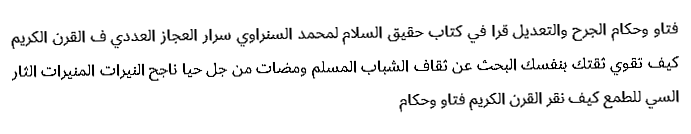

In [10]:
image = dataset[2]['image']
image

In [11]:
# dataset[2]['answer']

In [12]:
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
            },
            {
                "type": "text",
                "text": "extract the arabic text in the following image"
            }
        ]
    }
]

text_prompt = processor.apply_chat_template(messages, add_generation_prompt=True)



In [13]:
def qwen_extract_ocr(text_prompt,image):
    
    inputs = processor(
        text = [text_prompt],
        images = [image],
        padding = True,
        return_tensors = "pt"
    )

    inputs = inputs.to("cuda")

    output_ids = model.generate(**inputs, max_new_tokens=1024)

    generated_ids = [
        output_ids[len(input_ids) :]
        for input_ids, output_ids in zip(inputs.input_ids, output_ids)
    ]

    output_text = processor.batch_decode(
        generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True
    )
    return output_text


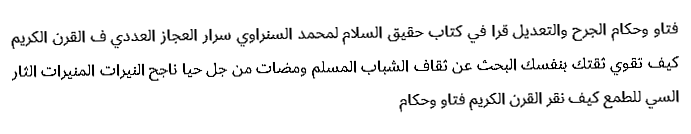

In [14]:
image = dataset[2]['image']
image

In [15]:
qwen_extract_ocr(text_prompt,image=dataset[2]['image'])


['Here is the Arabic text extracted from the image:\n\nفتاوا وحكم الجرح والتعديل قرأ في كتاب حقيق السلام لمحمد السنواني سرار العجزي العديدي في القرن الكريم كيف تقوي نقته بنفسه البحث عن ثقاف الشباب المسلم ومصات من جل حيا ناجح النبرات المنيرات الثار السي للطمع كيف نقر القرن الكريم فتاوا وحكم']

In [16]:

for i, sample in enumerate(results):
    torch.cuda.empty_cache()
    image = sample['image'].resize((512,512))
    text_result = " ".join(qwen_extract_ocr(text_prompt,image=image)).replace("The Arabic text in the image is:\n\n","")
    print(text_result)
    print("*****"*40)
    results[i]['qwenv2.5_3B'] = text_result

المقيم العلمي للروح من المنظور الإسلامي انتشار السلام بحد السيف بين الحقائق والاعتبار عاثث يبت بكر رضي الله عنهما طفانه وادناها العلماني في ضوء الفكر السلمي هل تسالات ضعف التربى الروحي البدين المغشوش حذروا المهمكات فتاوا وحكم
********************************************************************************************************************************************************************************************************
Here's the Arabic text extracted from the image:

"فقال وحكم السن والحديث قرأ في كتاب سماح السلم في العمل الله المتفهم العلمي لتسبيح الكائنات لرب العالمين ندو بالقائم حوار بين سر مسلم التبشيرات المثيرة كفال اليتيم الصبر على اليدا عمك في يومنك تر اليمان في المجتمع هيا تمن فتاوا وحكم"
********************************************************************************************************************************************************************************************************
Here is the Arabic text extracted from the image:

```
فقام وحكم الحج والعديد قرأ في كتا

In [17]:
import re

def remove_diacritics(text):
    diacritics = [
        '\u0617', '\u0618', '\u0619', '\u061A',  # Small high signs
        '\u064B', '\u064C', '\u064D', '\u064E', '\u064F', '\u0650',  # Tanween and basic diacritics
        '\u0651', '\u0652', '\u0653', '\u0654', '\u0655', '\u0656',  # Shadda, sukun, etc.
        '\u0657', '\u0658', '\u0659', '\u065A', '\u065B', '\u065C', 
        '\u065D', '\u065E', '\u065F', '\u0670'   # Additional Arabic diacritics
    ]
    pattern = '[' + ''.join(diacritics) + ']'
    return re.sub(pattern, '', text)
def remove_english_letters(text):
    # Regex pattern to match English letters (a-z and A-Z)
    pattern = r'[a-zA-Z]'
    # Replace English letters with an empty string
    cleaned_text = re.sub(pattern, '', text)
    return cleaned_text

In [18]:
df = pd.DataFrame(results)
df.head()

,image,ground_truth,qwenv2.5_3B
0,<PIL.Image.Image image mode=RGB size=689x126 at 0x7FDB28C62990>,المفهوم العلمي للروح من المنظور الاسلام انتشار السلام بحد السيف بين الحقيق والافترا عاش بنت بي بكر رضي الله عنهما طفالنا والذكا العلماني في ضو الفكر السلامي هل تسالات ضعف التربي الروحي التدين المغشوش حذروا المهلكات فتاو وحكام,المقيم العلمي للروح من المنظور الإسلامي انتشار السلام بحد السيف بين الحقائق والاعتبار عاثث يبت بكر رضي الله عنهما طفانه وادناها العلماني في ضوء الفكر السلمي هل تسالات ضعف التربى الروحي البدين المغشوش حذروا المهمكات فتاوا وحكم
1,<PIL.Image.Image image mode=RGB size=689x128 at 0x7FDB28B02290>,فتاو وحكام السن والحديث قرا في كتاب سماح السلام في الدعو ل الله المفهوم العلمي لتسبيح الكانات لرب العالمين ندو بالقاهر حوار بين سر مسلم النيرات المنيرات كفال اليتيم الصبر عل البلا عمرك في يومك ثر اليمان في المجتمع هيا نمن فتاو وحكام,"Here's the Arabic text extracted from the image:\n\n""فقال وحكم السن والحديث قرأ في كتاب سماح السلم في العمل الله المتفهم العلمي لتسبيح الكائنات لرب العالمين ندو بالقائم حوار بين سر مسلم التبشيرات المثيرة كفال اليتيم الصبر على اليدا عمك في يومنك تر اليمان في المجتمع هيا تمن فتاوا وحكم"""
2,<PIL.Image.Image image mode=RGB size=691x134 at 0x7FDB2B7B2210>,فتاو وحكام الجرح والتعديل قرا في كتاب حقيق السلام لمحمد السنراوي سرار العجاز العددي ف القرن الكريم كيف تقوي ثقتك بنفسك البحث عن ثقاف الشباب المسلم ومضات من جل حيا ناجح النيرات المنيرات الثار السي للطمع كيف نقر القرن الكريم فتاو وحكام,Here is the Arabic text extracted from the image:\n\n```\nفقام وحكم الحج والعديد قرأ في كتاب حقائق السلام لمحمد السراوي سرار العجز العدي في القرن الكريم كيف تقوي تقدمك بتفسير البحث عن نفاذ الشباب المسلم ومصات من جل حيا ناجح المديرات الثار السي للتمع كيف تقر القرن الكريم فقام وحكم\n```
3,<PIL.Image.Image image mode=RGB size=691x170 at 0x7FDB285BA650>,نادي نزو يحتف بختام نشطته الصيفي نشط ثقافي متنوع تنطلق في عاصم الثقاف العربي صنعا وزير الشون الجتماعي اللبناني يحذر العرب من الهجم الشرس لتحطيم عناصر قوتهم عدد جديد من مجل الهلال مشارك تشكيلي سوري في معرض فرانكفورت افتتاح هاد ونيق لمهرجان الاسكندري السينماي كل سبت نادي نزو يحتف بختام نشطته الصيفي,Here's the Arabic text extracted from the image:\n\nنادي نزو يحتفظ بختم نشطته الصيفي نشط تقافي متوقع تتطلق في عاصم الثقاف العربي صنعا وزيز الشون\n\nالاجتماعي اللبناني يحذر العرب من الهجم الشرس لحطم عناصر قوتهم عدد جديد من مجال الالبال مشارك\n\nتشكلي سوري في معرض فرانكفورت افتتاح هاد ونينق لمهرجان الاسكندري السيمنتي كل سبت نادي نزو\n\nيحتفظ بختم نشطته الصيفي
4,<PIL.Image.Image image mode=RGB size=689x160 at 0x7FDB20163350>,مسي شعري بالرستاق وزار التراث والثقاف تعلن عن اسما الفرق المسرحي الاهلي المشارك في مهرجان المسرح العماني الاول يقدم الدنيا حظوظ في رمضان القادم الكوميدي العراقي عامر العمري في حديث ل الوطن يحي عياش يعود من جديد من خلال الدراما السوري بيت ديكسون شاهد عل العمار التقليدي الكويتي مرايا مقاربات مسي شعري بالرستاق,Here's the Arabic text extracted from the image:\n\nمسى شعري بالرستاق وزار التراث والثقاف تعنى عن اسما الفرق المسرحي الاهلی المشارک في مهرجان\n\nالمسرح العماني الامل يقدم الدنيا خطوط في رمضان القادم الكوميدي العراقي عامر العمري في حديث ل\n\nالوطن يحي عياش يجود من جديد من خلال الدراما السوري يتیدكسوس شاهد على العمار التقليدي الكويتی\n\nمرايا مقاربات مسی شعري بالرستاق


In [19]:
df['ground_truth'] = df['ground_truth'].apply(remove_english_letters)
df['qwenv2.5_3B'] = df['qwenv2.5_3B'].apply(remove_english_letters)

In [20]:

df['ground_truth_t'] = df["ground_truth"].apply(remove_diacritics)
df['qwenv2.5_3B_t'] = df["qwenv2.5_3B"].apply(remove_diacritics)


In [21]:
df.head()

,image,ground_truth,qwenv2.5_3B,ground_truth_t,qwenv2.5_3B_t
0,<PIL.Image.Image image mode=RGB size=689x126 at 0x7FDB28C62990>,المفهوم العلمي للروح من المنظور الاسلام انتشار السلام بحد السيف بين الحقيق والافترا عاش بنت بي بكر رضي الله عنهما طفالنا والذكا العلماني في ضو الفكر السلامي هل تسالات ضعف التربي الروحي التدين المغشوش حذروا المهلكات فتاو وحكام,المقيم العلمي للروح من المنظور الإسلامي انتشار السلام بحد السيف بين الحقائق والاعتبار عاثث يبت بكر رضي الله عنهما طفانه وادناها العلماني في ضوء الفكر السلمي هل تسالات ضعف التربى الروحي البدين المغشوش حذروا المهمكات فتاوا وحكم,المفهوم العلمي للروح من المنظور الاسلام انتشار السلام بحد السيف بين الحقيق والافترا عاش بنت بي بكر رضي الله عنهما طفالنا والذكا العلماني في ضو الفكر السلامي هل تسالات ضعف التربي الروحي التدين المغشوش حذروا المهلكات فتاو وحكام,المقيم العلمي للروح من المنظور الإسلامي انتشار السلام بحد السيف بين الحقائق والاعتبار عاثث يبت بكر رضي الله عنهما طفانه وادناها العلماني في ضوء الفكر السلمي هل تسالات ضعف التربى الروحي البدين المغشوش حذروا المهمكات فتاوا وحكم
1,<PIL.Image.Image image mode=RGB size=689x128 at 0x7FDB28B02290>,فتاو وحكام السن والحديث قرا في كتاب سماح السلام في الدعو ل الله المفهوم العلمي لتسبيح الكانات لرب العالمين ندو بالقاهر حوار بين سر مسلم النيرات المنيرات كفال اليتيم الصبر عل البلا عمرك في يومك ثر اليمان في المجتمع هيا نمن فتاو وحكام,"' :\n\n""فقال وحكم السن والحديث قرأ في كتاب سماح السلم في العمل الله المتفهم العلمي لتسبيح الكائنات لرب العالمين ندو بالقائم حوار بين سر مسلم التبشيرات المثيرة كفال اليتيم الصبر على اليدا عمك في يومنك تر اليمان في المجتمع هيا تمن فتاوا وحكم""",فتاو وحكام السن والحديث قرا في كتاب سماح السلام في الدعو ل الله المفهوم العلمي لتسبيح الكانات لرب العالمين ندو بالقاهر حوار بين سر مسلم النيرات المنيرات كفال اليتيم الصبر عل البلا عمرك في يومك ثر اليمان في المجتمع هيا نمن فتاو وحكام,"' :\n\n""فقال وحكم السن والحديث قرأ في كتاب سماح السلم في العمل الله المتفهم العلمي لتسبيح الكائنات لرب العالمين ندو بالقائم حوار بين سر مسلم التبشيرات المثيرة كفال اليتيم الصبر على اليدا عمك في يومنك تر اليمان في المجتمع هيا تمن فتاوا وحكم"""
2,<PIL.Image.Image image mode=RGB size=691x134 at 0x7FDB2B7B2210>,فتاو وحكام الجرح والتعديل قرا في كتاب حقيق السلام لمحمد السنراوي سرار العجاز العددي ف القرن الكريم كيف تقوي ثقتك بنفسك البحث عن ثقاف الشباب المسلم ومضات من جل حيا ناجح النيرات المنيرات الثار السي للطمع كيف نقر القرن الكريم فتاو وحكام,:\n\n```\nفقام وحكم الحج والعديد قرأ في كتاب حقائق السلام لمحمد السراوي سرار العجز العدي في القرن الكريم كيف تقوي تقدمك بتفسير البحث عن نفاذ الشباب المسلم ومصات من جل حيا ناجح المديرات الثار السي للتمع كيف تقر القرن الكريم فقام وحكم\n```,فتاو وحكام الجرح والتعديل قرا في كتاب حقيق السلام لمحمد السنراوي سرار العجاز العددي ف القرن الكريم كيف تقوي ثقتك بنفسك البحث عن ثقاف الشباب المسلم ومضات من جل حيا ناجح النيرات المنيرات الثار السي للطمع كيف نقر القرن الكريم فتاو وحكام,:\n\n```\nفقام وحكم الحج والعديد قرأ في كتاب حقائق السلام لمحمد السراوي سرار العجز العدي في القرن الكريم كيف تقوي تقدمك بتفسير البحث عن نفاذ الشباب المسلم ومصات من جل حيا ناجح المديرات الثار السي للتمع كيف تقر القرن الكريم فقام وحكم\n```
3,<PIL.Image.Image image mode=RGB size=691x170 at 0x7FDB285BA650>,نادي نزو يحتف بختام نشطته الصيفي نشط ثقافي متنوع تنطلق في عاصم الثقاف العربي صنعا وزير الشون الجتماعي اللبناني يحذر العرب من الهجم الشرس لتحطيم عناصر قوتهم عدد جديد من مجل الهلال مشارك تشكيلي سوري في معرض فرانكفورت افتتاح هاد ونيق لمهرجان الاسكندري السينماي كل سبت نادي نزو يحتف بختام نشطته الصيفي,' :\n\nنادي نزو يحتفظ بختم نشطته الصيفي نشط تقافي متوقع تتطلق في عاصم الثقاف العربي صنعا وزيز الشون\n\nالاجتماعي اللبناني يحذر العرب من الهجم الشرس لحطم عناصر قوتهم عدد جديد من مجال الالبال مشارك\n\nتشكلي سوري في معرض فرانكفورت افتتاح هاد ونينق لمهرجان الاسكندري السيمنتي كل سبت نادي نزو\n\nيحتفظ بختم نشطته الصيفي,نادي نزو يحتف بختام نشطته الصيفي نشط ثقافي متنوع تنطلق في عاصم الثقاف العربي صنعا وزير الشون الجتماعي اللبناني يحذر العرب من الهجم الشرس لتحطيم عناصر قوتهم عدد جديد من مجل الهلال مشارك تشكيلي سوري في معرض فرانكفورت افتتاح هاد ونيق لمهرجان الاسكندري السينماي 

In [22]:
from jiwer import wer, cer 

# for model in ["tesseract","easyocr"]:
for model in ["qwenv2.5_3B"]:
    wer_score = wer(df["ground_truth"].tolist(), df[model].tolist())
    cer_score = cer(df["ground_truth"].tolist(), df[model].tolist())
    print(f"{model} - WER: {wer_score:.2f}, CER: {cer_score:.2f}")

qwenv2.5_3B - WER: 0.42, CER: 0.24


In [23]:
from jiwer import wer, cer 

# for model in ["tesseract","easyocr"]:
for model in ["qwenv2.5_3B_t"]:
    wer_score = wer(df["ground_truth_t"].tolist(), df[model].tolist())
    cer_score = cer(df["ground_truth_t"].tolist(), df[model].tolist())
    print(f"{model} - WER: {wer_score:.2f}, CER: {cer_score:.2f}")

qwenv2.5_3B_t - WER: 0.41, CER: 0.24


In [24]:
df.to_csv("khattat_dl_arabicocr_result.csv")